In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.datasets as datasets
# from torchvision.datasets import MNIST
from keras.datasets import mnist
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision import transforms
import torchvision
import torchsummary

from networks.generator import ResNetGenerator, Decoder, Encoder, ResNetUnetGenerator

Using TensorFlow backend.
/home/danjiii/Program/ML_practice/data-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/danjiii/Program/ML_practice/data-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/danjiii/Program/ML_practice/data-venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
simple = transforms.Compose([
    transforms.ToTensor(),
])
mnist_trainset = datasets.MNIST(root='./datasets/mnist', train=True, download=True, transform=simple)

In [6]:
model1 = ResNetUnetGenerator(c_dim=1, conv_dim=32, repeat_num=2, n_down=2)
encoder = Encoder()
torchsummary.summary(model1, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
    InstanceNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,608
    InstanceNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           9,216
    InstanceNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 64, 14, 14]          18,432
   InstanceNorm2d-11           [-1, 64, 14, 14]             128
             ReLU-12           [-1, 64, 14, 14]               0
DownsamplingBlock-13           [-1, 64, 14, 14]               0
           Conv2d-14            [-1, 12

In [7]:
model1.decoder.decoder[-1]

Sequential(
  (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (3): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (5): Tanh()
)

In [8]:
model1.decoder.skip

ModuleList(
  (0): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
)

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))  # adapt this if using `channels_first` i

In [11]:
x_train[0].shape

(1, 28, 28)

In [12]:
def salt_and_pepper(x_train,x_test,factor):
    noise_factor = factor
    
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [13]:
def gaussian_noise(x_train,x_test,sigma):
    row,col,ch= x_train[0].shape
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    x_test_noisy = skimage.util.random_noise(x_test, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [14]:
def gamma_noise(x_train,x_test,shape,scale=1.0):
    
    row,col,ch = x_train[0].shape
    
    x_train_noisy = x_train + np.random.gamma(shape,scale,x_train.shape)
    x_test_noisy = x_test + np.random.gamma(shape,scale,x_test.shape)
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [15]:
x_train_noisy, x_test_noisy = gamma_noise(x_train,x_test,0.5)
class Mnistdenoizing_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, x_train_noisy):
        self.x_train_noisy = x_train_noisy
        self.x_train = x_train
        
    def __getitem__(self, idx):
        return (torch.tensor(self.x_train[idx], requires_grad=True).type(torch.float), 
        torch.tensor(self.x_train_noisy[idx], requires_grad=True).type(torch.float))
    
    def __len__(self):
        return len(self.x_train)

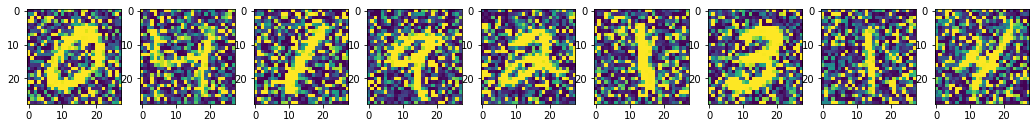

In [16]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
plt.show()

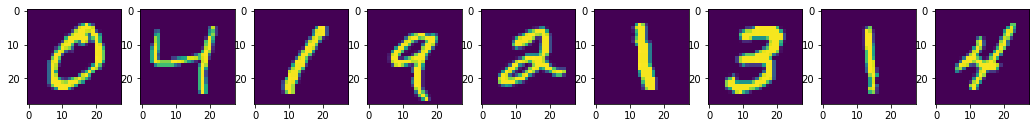

In [17]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
plt.show()

In [18]:
for param in model1.parameters():
#     param.data = param.data.float()
    print(torch.typename(param.data))

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor


In [19]:
device = torch.device('cpu')
model1 = model1.float()

In [20]:
BATCH_SIZE = 1
criterian = nn.MSELoss()
d = Mnistdenoizing_dataset(x_train, x_train_noisy)
def init_weight(layer):
    if type(layer) == nn.Conv2d or type(layer) == nn.ConvTranspose2d:
        torch.nn.init.uniform_(layer.weight)
# model1.apply(init_weight)
def train(model, num_epoch=10, gd=None):
    if gd is None:
        gd = optim.Adam(model.parameters())
    dataloader = DataLoader(d, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    for epoch in tqdm(range(num_epoch)):
        model.train(True)
        for i, batch in enumerate(dataloader):
            gd.zero_grad()
            f = model(batch[1])
            loss = criterian(batch[0], f)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
#         for i, (batch) in enumerate(dataloader_test):
#             batch = batch.to(device=device)
#             scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
#         test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}")

In [21]:
# (list(model1.parameters()) + list(map(lambda x: x.parameters(), model1.decoder.skip)))
# model1 = model1.float()
# torch.set_default_tensor_type('torch.FloatTensor')
train(model1)
# model1.parameters

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
dataloader = DataLoader(d, batch_size=BATCH_SIZE, shuffle=True)
a, b  = next(iter(dataloader))

In [ ]:
# plt.imshow(b[0][0])
# a.requires_grad
# a.shape
# model1(a).shape
# a = torch.tensor(np., dtype=torch.float)
# a = a.double()
# model1.decoder.skip[0](a)
a.shape

In [76]:
with torch.no_grad():
    res = model1.forward(torch.tensor(x_test_noisy[8]).float().unsqueeze(0))

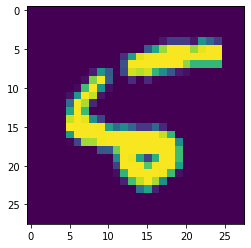

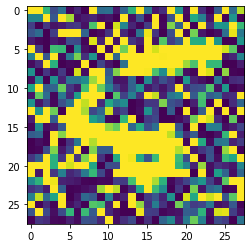

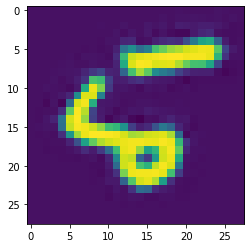

In [77]:
plt.imshow(x_test[8][0])
plt.show()
plt.imshow(x_test_noisy[8][0])
plt.show()
plt.imshow(res.detach().numpy()[0][0])
plt.show()